In [364]:
import math
import seaborn
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.api import qqplot

Before EDA, we will need the following function to generate the coefficients for differencings. Notice that first order differencing is given by $dA_t = A_t-A_{t-1}$. So for the input n=1, the output will be [1,-1]. Similarly, it is easy to obtain that the second order differencing formula $d^2A_t=A_t-2A_{t-1}+A_{t-2}$. And thus for the input n=2, the function outputs [1, -2, 1]. So on and so forth. 

In [330]:
def diff(arr):
    return [(arr[i+1]-arr[i]) for i in range(len(arr)-1)]

In [216]:
def generateCoeffs(n):
    if n == 0:
        return [1]
    
    coeff = [1, 1]
    i = 1
    
    while i < n:
        new_coeff = [1]
        
        for j in range(len(coeff)-1):
            new_coeff.append(coeff[j]+coeff[j+1])
        new_coeff.append(1)
        coeff = new_coeff
        i += 1
        
    return [coeff[i]*((-1)**i) for i in range(n+1)]   

In [217]:
# loop through all files to extract ROI time-series from each patients
subjects = []

for i in range(1,143):
    fileName = 'sub_'+str(i)+'.mat'
    file = scipy.io.loadmat(fileName)
    subjects.append(file['tc_filt'])  
    

Next we use Augmented Dickey-Fuller Test on stationarity. It is a test on whether the process is a unit-root process. An easy observation is that unit-root series are not stationary. In particular, for AR(1) process, if it has a unit root, then the variance grow linearly with time. Here null hypothesis is that the series has a unit (thus non-stationary). 

In the test, we consider 95% confidence level. To reject null hypothesis and conclude that series is stationary, the statistics need to be above significance level, in this case given by test[0].

The following section continues to run differencing until all regions of all subjects get to perfect stationarity.

In [218]:
# sttnry_map[k] stores stationary map for the kth order differencing
sttnry_map = []
# sttnry_roi_counts[k][l] stores the number subjects that have l stationary ROI's after k differencings
sttnry_roi_counts = [] 
# all_subject_perfect determines whether after differencings all ROI's of all subjects become stationary
all_perfect = False
# initlaize number or differencing needed to make perfect stationarity
d = -1
# diff_needed_for[subject][region] takes down the number of differencings needed to stationarize the corresponding region 
# a subject
diff_needed_for = [[-1 for _ in range(160)] for _ in range(142)]
# all_stationary is a flag to signal the stop of the loop, when all regions of all patiens become stationary
all_stationary = False

In [223]:
while not all_stationary:
    d += 1
    this_order_sttnry_map = []
    this_order_sttnry_roi_counts = []
    coeff = generateCoeffs(d)
    for sub in range(len(subjects)):
        count = 0
        sub_sttnry = []
    
        for region in range(len(subjects[sub][0])):
            if diff_needed_for[sub][region] == -1: # not yet stationarized
                df = []
                for t in range(len(subjects[sub]) - d):
                    temp = 0
                
                    for i in range(d+1):
                        temp += subjects[sub][t + d-i, region]*coeff[i]
                    df.append(temp)
                
                ADF_test = adfuller(df)
        
                if ADF_test[4]['5%'] > ADF_test[0]:  
                    sub_sttnry.append(1)
                    count += 1
                    diff_needed_for[sub][region] = d
                else:
                    sub_sttnry.append(0)
            else:
                sub_sttnry.append(1)
                count += 1
                    
        this_order_sttnry_roi_counts.append(count) 
        this_order_sttnry_map.append(sub_sttnry)
        
    all_stationary = all([count ==160 for count in this_order_sttnry_roi_counts])
    sttnry_map.append(this_order_sttnry_map)
    sttnry_roi_counts.append(this_order_sttnry_roi_counts)

In [224]:
print("It takes "+str(len(sttnry_map))+" differencings to get perfect stationarity across all regions and all subjects.")

It takes 7 differencings to get perfect stationarity across all regions and all subjects.


In [406]:
diff = 3

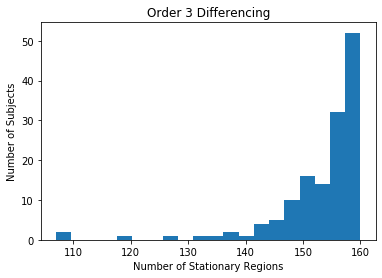

In [407]:
plt.hist(sttnry_roi_counts[diff],20)
plt.title('Order '+str(diff)+' Differencing')
plt.xlabel('Number of Stationary Regions')
plt.ylabel('Number of Subjects')
plt.show()

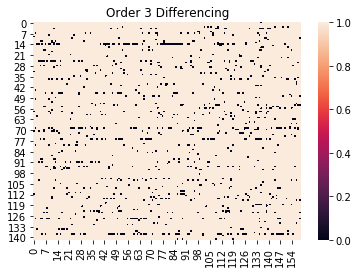

In [408]:
seaborn.heatmap(sttnry_map[diff])
plt.title('Order '+str(diff)+' Differencing')
plt.show()

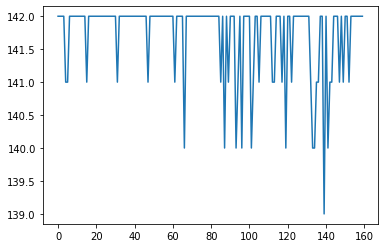

In [410]:
region_sum = [0 for _ in range(len(sttnry_map[1][0]))]
for region in range(len(sttnry_map[1][0])):
    for subject in range(len(sttnry_map[1])):
        region_sum[region] += sttnry_map[4][subject][region] 
plt.plot(region_sum)
plt.show()

Extract the most non-stationary subjects after 1st differencing for further inspection.

It seems that we are finally done! However, we still have to do a sanity check. Take the last ROI of the last subject for inspection. 

In [291]:
# testing ARIMA pipeline on a sample time-series: the 160-th ROI of subject 142
sample_ts = df

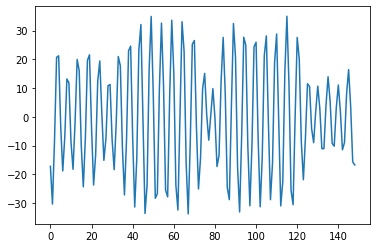

In [292]:
# Take a look at the 7th order differenced signal. 
plt.plot(sample_ts)
plt.show()

In [293]:
corr = np.correlate(sample_ts,sample_ts,mode='full')
corr = corr[len(corr)//2:]/max(corr)
print(corr)
print("The Lag-1 auto-correlations is " +str(corr[1]))

[ 1.          0.35231684 -0.73468082 -0.8405193   0.14284632  0.89950651
  0.45183316 -0.5664631  -0.794409    0.0379062   0.78765496  0.46001212
 -0.47308512 -0.74490884 -0.00862116  0.72204814  0.46487304 -0.41319103
 -0.71804158 -0.05046353  0.67279389  0.47735848 -0.35680649 -0.69520694
 -0.09122447  0.62488383  0.48635718 -0.30561317 -0.67276922 -0.12736905
  0.58031432  0.49383715 -0.25621299 -0.64593814 -0.15485244  0.53777264
  0.48842561 -0.22846086 -0.63050985 -0.16779853  0.53085381  0.51285665
 -0.20575626 -0.65887572 -0.23158122  0.51123387  0.58040711 -0.11656326
 -0.65661543 -0.33208774  0.41818442  0.60597843  0.00262996 -0.58111494
 -0.38722837  0.29988673  0.56357826  0.07943525 -0.48397313 -0.38430716
  0.21593205  0.5026705   0.11179301 -0.40959124 -0.36549003  0.1614911
  0.45226659  0.13107532 -0.35037971 -0.3467367   0.1161827   0.4038235
  0.14197243 -0.29634473 -0.31896656  0.08654521  0.35945892  0.13806207
 -0.26307933 -0.29825889  0.06987148  0.33604136  0.1

The Lag-1 correlation is positive, which is a good sign. Lets take a closer look on the ACF plot.

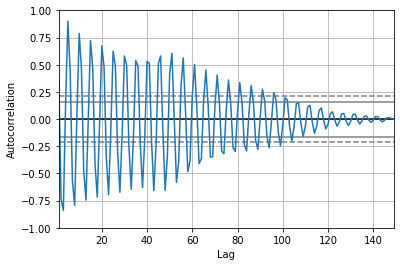

In [275]:
sample_ts = pd.DataFrame(sample_ts)
pd.plotting.autocorrelation_plot(sample_ts)
plt.show()

Now we have a problem. The autocorrelation quickly steps into far negative zone and oscillate all the way through. This simply means that this time-series is over-differenced. It is very possible that a lot of the other time-series are also over-differenced. What is the consequence of having it over-differenced? Basically we lost all the ARMA features and are left with useless stuff. This means that we cannot blindly difference the series until it hit stationarity beacause this will naturally lead to over-differencing. 

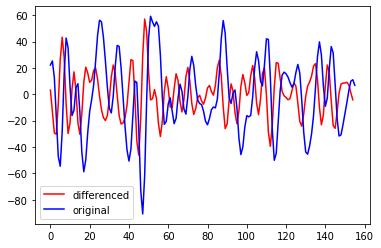

In [376]:
ts = subjects[0][:,1] # extracting the region 1 of the first subject 
diff_ts = diff(ts)
plt.plot(diff_ts, color = 'r',label='differenced')
plt.plot(ts, color = 'b', label='original')
plt.legend()
plt.show()

In [336]:
ts_corr = np.correlate(ts,ts,mode='full')
ts_corr = corr[len(corr)//2:]/max(corr)
print("The auto-correlation of the target time-series is computed as:")
print(corr)
print("The Lag-1 auto-correlations is " +str(corr[1]))

The auto-correlation of the target time-series is computed as:
[ 1.00000000e+00  8.19124758e-01  3.99482713e-01 -2.99275417e-03
 -2.08813644e-01 -2.30738318e-01 -2.02430360e-01 -2.21354857e-01
 -2.73912862e-01 -2.95685954e-01 -2.67882896e-01 -2.31660914e-01
 -2.18387454e-01 -1.96598846e-01 -1.07498077e-01  5.37214646e-02
  2.11219207e-01  2.72443954e-01  2.13509745e-01  9.48703001e-02
 -3.02484428e-03 -4.93162635e-02 -6.78947922e-02 -8.77158472e-02
 -1.04380656e-01 -9.35858143e-02 -5.01419785e-02 -2.23046828e-05
  2.80523918e-02  3.44944328e-02  4.57892818e-02  8.20584837e-02
  1.34047747e-01  1.73533052e-01  1.80924248e-01  1.57618484e-01
  1.13992744e-01  5.42206609e-02 -2.08290606e-02 -9.86225323e-02
 -1.52338129e-01 -1.60873989e-01 -1.32104224e-01 -1.01239831e-01
 -1.00678268e-01 -1.29246490e-01 -1.52009477e-01 -1.32030484e-01
 -6.35931677e-02  2.43785569e-02  9.54458664e-02  1.34501334e-01
  1.50947225e-01  1.57837190e-01  1.53229011e-01  1.24544073e-01
  6.89737554e-02  4.5461129

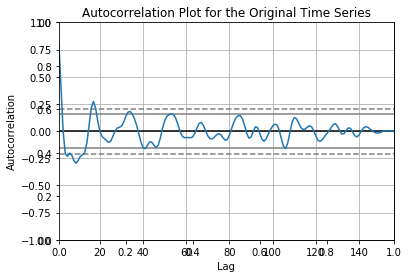

In [340]:
ts = pd.DataFrame(ts)
plt.title('Autocorrelation Plot for the Original Time Series')
pd.plotting.autocorrelation_plot(ts)
plt.show()

In [382]:
test = adfuller(ts)
if test[4]['5%']>test[0]:
    res = 'stationary'
else:
    res = 'non-stationary'
print('This particular time series is ' + res)

This particular time series is stationary


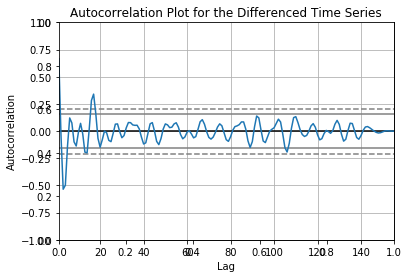

In [383]:
diff_ts = pd.DataFrame(diff_ts)
plt.title('Autocorrelation Plot for the Differenced Time Series')
pd.plotting.autocorrelation_plot(diff_ts)
plt.show()

The autocorrelation plot for the differenced signal indicates that the series is overdifferenced, as the plot quickly dive down to the far negative zone (<0.5). So we will not perform any differencing before testing out the ARMA models. Next we try to fit ARMA(1,0) and ARMA(2,0) and see how they do. 

In [369]:
arma_2_0 = ARMA(ts, (2,0)).fit()
arma_1_0 = ARMA(ts, (1,0)).fit()

Akaike Information Criterion (AIC) provides a comparison between the two arma model to the hidden true model (which we don't know). In priciple the smaller the score the higher the probability that the model is the true one. 

In [370]:
print(arma_2_0.aic, arma_1_0.aic)

1145.4326978528397 1324.0304241101821


So we should choose the ARMA(2,0) model. Now take a look at the residual plot. Ideally, we should want it to normally distributed. 

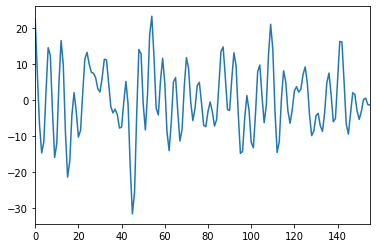

In [371]:
arma_2_0.resid.plot()
plt.show()

It seems fine. Now to confirm that lets plot quantile-quantile plot (qq-plot) against the nornal distribution. 

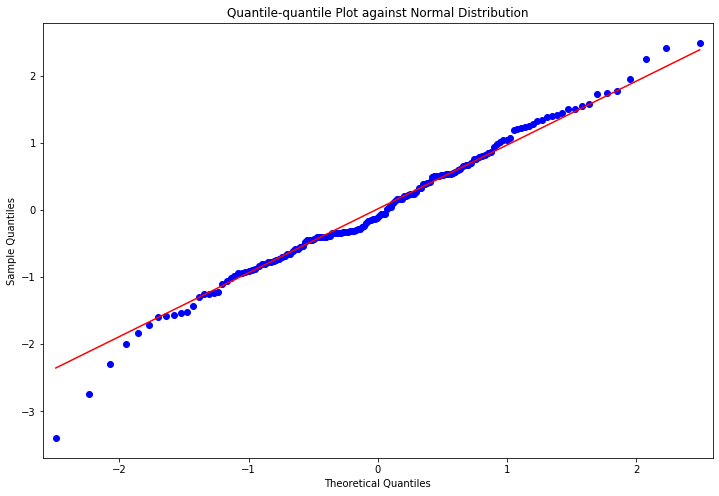

In [361]:
fig = plt.figure(figsize=(12,8))
resid = arma_3_0.resid
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.title("Quantile-quantile Plot against Normal Distribution")
plt.show()

The residuals look healthily distributed, meaning that the fitted model actually satisfies the assumption or the model (this sounds a little cyclic but is the best we can get). Lets take a look at the fit. 

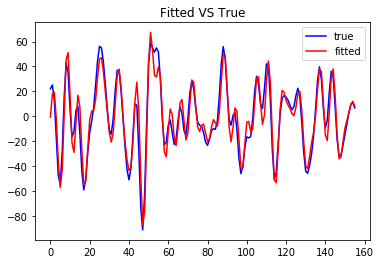

In [378]:
plt.plot(ts, color='b', label='true')
predict = arma_2_0.predict()
plt.plot(predict, color='r', label='fitted')
plt.title("Fitted VS True")
plt.legend()
plt.show()

The fit is very good! To compare the fit with LSTM, we could either just compute the AIC/BIC or just the MSE.